In [1]:
# import necessary packages for geospatial analysis and data processing

import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point

print("Packages imported successfully!")

Packages imported successfully!


In [2]:
# Osprey nests data
osprey_nests_df = pd.read_excel('CapstoneData/Osprey Data, Confirmed Nests as of 8.2.2023.xlsx', sheet_name='Outages, 2018-Current')

# Convert pandas DataFrame to GeoDataFrame
osprey_nests_df = gpd.GeoDataFrame(osprey_nests_df, geometry=gpd.points_from_xy(osprey_nests_df.faultlongitude, osprey_nests_df.faultlatitude))

# Outages data
outages_df = gpd.read_file('CapstoneData/Outages01012020through09012023.csv')

# Confirmed nests data
osprey_confirmed_nests = pd.read_excel('CapstoneData/Osprey Data, Confirmed Nests as of 8.2.2023.xlsx', sheet_name='Confirmed Osprey Nests')

# Map data
map_data = gpd.read_file('CapstoneData/NY_Waterbody_List.geojson')


In [3]:
# remove rows from outages_df where 'CauseDesc' is 'Animal - Bird Contact'
outages_df = outages_df[outages_df.CauseDesc != 'Animal - Bird Contact']

In [4]:
outages_df.shape

(175523, 93)

In [5]:
grouped_outages = outages_df.groupby('OPCO')

# Create separate DataFrames for each group
outages_by_opco = {opco: group for opco, group in grouped_outages}

outages_nyseg = outages_df[outages_df.OPCO=='NYSEG']
outages_rge = outages_df[outages_df.OPCO=='RGE']
outages_cmp = outages_df[outages_df.OPCO=='CMP']
outages_ui = outages_df[outages_df.OPCO=='UI']

outages_nyseg

,OPCO,Incident,IncSeqNo,OPCOIncStartNo,GroupNo,MalfStartDate,MalfStartTime,MalfEndDate,MalfEndTime,Duration,...,faultlongitude,ServiceCenter,ECC_OperatorLog,ThirdPartyAttacher,UI_TREE_CONTACT_TYPE_DESC,FaultFlocAlgoSource,DerivedFaultCircuit,WeatherIndex,iCDSOutageRemark,geometry
2,NYSEG,1022871,0,672775,0,9/1/2023,2:57:00,9/1/2023,11:30:00,8.55,...,-74.73475,ECC,NULL,NULL,NULL,FuzzyDistPUB_Poles,2402820,23,"09/01 08:37-ETR update per crew, 09/01 11:43-0...",None
3,NYSEG,1023175,0,672824,0,9/1/2023,19:01:00,9/2/2023,1:00:00,5.983,...,-74.80134,ECC,NULL,NULL,NULL,FuzzyDistPUB_Poles,2401970,37,"09/01 07:06-EI05 Created by Vought, John[Vough...",None
4,NYSEG,1022878,0,672776,0,9/1/2023,6:04:00,9/1/2023,8:40:00,2.6,...,-75.29912,ECC,NULL,NULL,NULL,FuzzyDistPUB_Poles,2308417,20,09/01 07:09-waiting for morning crews to arriv...,None
12,NYSEG,1022902,0,672780,0,9/1/2023,7:50:00,9/1/2023,8:10:00,0.333,...,-78.682774,ECC,NULL,NETSPEED MANAGEMENT INC.,NULL,FuzzyDistPUB_Poles,3200502,18,09/01 07:47-Mark w/ OConnell 850.545.8282 taki...,None
14,NYSEG,1022907,0,672786,0,9/1/2023,8:15:00,9/1/2023,9:52:00,1.617,...,-76.794558,ECC,NULL,EMPIRE LONG DISTANCE CORPORATION,NULL,FuzzyDistPUB_Poles,5200989,20,09/01 07:58-Matt W/ D and D power - 607 727 29...,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177025,NYSEG,361102,0,108601,0,1/1/2020,8:45:00,1/1/2020,9:30:00,0.75,...,-74.727862,Open Event,NULL,NULL,NULL,FuzzyDistPUB_Poles,2401311,45,01/01 08:46-ASSIGNED HR ENGINEER PAUL BATZ,None
177026,NYSEG,361126,0,108606,35292,1/1/2020,9:30:00,1/1/2020,10:45:00,1.25,...,-75.854838,ECC,NULL,NULL,NULL,FuzzyDistPUB_Poles,8101701,38,"01/01 09:35-[Lindenmuth, Brian(U336458) : 01.0...",None
177027,NYSEG,361114,0,108607,0,1/1/2020,9:35:00,1/1/2020,11:35:00,2,...,-73.706797,ECC,NULL,NULL,NULL,FuzzyDistPUB_Strucs,1106108,32,01/01 09:42-ASSIGNED HR ENGINEER Maloney James...,None
177028,NYSEG,361122,0,108608,0,1/1/2020,9:39:00,1/1/2020,11:00:00,1.35,...,-74.771343,Open Event,Ok for ESO to commence switching the 34.5kV 34...,NULL,NULL,FuzzyDistPUB_Poles,2401842,42,01/01 09:47-Location LIBERTY142FA4.8 - OLD LOO...,None


In [6]:
#  only choose columns 'OPCO', 'CustomerCount', CircuitVoltage', 'Division', 'CauseDesc', 'faultlatitude', 'faultlongitude' from outages_nyseg
outages_nyseg = outages_nyseg[['OPCO', 'CustomerCount', 'CircuitVoltage', 'Division', 'CauseDesc', 'faultlatitude', 'faultlongitude']]
#  only choose columns 'OPCO', 'CustomerCount', CircuitVoltage', 'Division', 'CauseDesc', 'faultlatitude', 'faultlongitude' from outages_rge
outages_rge = outages_rge[['OPCO', 'CustomerCount', 'CircuitVoltage', 'Division', 'CauseDesc', 'faultlatitude', 'faultlongitude']]

In [7]:
# Filter out records with missing longitude or latitude values
outages = outages_nyseg[(outages_nyseg['faultlongitude'] != '') & (outages_nyseg['faultlatitude'] != '')]
outages = outages_rge[(outages_rge['faultlongitude'] != '') & (outages_rge['faultlatitude'] != '')]


# concatenate outages_nyseg and outages_rge
outages = pd.concat([outages_nyseg, outages_rge])

In [8]:
# Replace empty strings with NaN
outages['faultlongitude'] = outages['faultlongitude'].replace('', np.nan)
outages['faultlatitude'] = outages['faultlatitude'].replace('', np.nan)

outages['faultlongitude'] = outages['faultlongitude'].replace('NULL', np.nan)
outages['faultlatitude'] = outages['faultlatitude'].replace('NULL', np.nan)
# Drop rows with NaN values
outages = outages.dropna(subset=['faultlongitude', 'faultlatitude'])

# Convert to GeoDataFrame
outages = gpd.GeoDataFrame(outages, geometry=gpd.points_from_xy(outages.faultlongitude.astype(float), outages.faultlatitude.astype(float)))


In [9]:
outages.shape

(85373, 8)

In [10]:
grouped_nests = osprey_nests_df.groupby('OPCO')

# Create separate DataFrames for each group
osprey_nests_by_opco = {opco: group for opco, group in grouped_nests}

nests_nyseg = osprey_nests_df[osprey_nests_df.OPCO=='NYSEG']
nests_rge = osprey_nests_df[osprey_nests_df.OPCO=='RGE']
nests_cmp = osprey_nests_df[osprey_nests_df.OPCO=='CMP']
nests_ui = osprey_nests_df[osprey_nests_df.OPCO=='UI']

In [11]:
osprey_nests = pd.concat([nests_nyseg, nests_rge])
osprey_nests.shape

(4583, 19)

In [12]:
# only choose columns 'CauseDesc', 'Division', 'CustomerCount', 'OPCO','faultlatitude','faultlongitude' from osprey_nests
osprey_nests = osprey_nests[['CauseDesc', 'Division', 'CustomerCount', 'OPCO','faultlatitude','faultlongitude']]
# Filter out records with missing longitude or latitude values
osprey_nests = osprey_nests[(osprey_nests['faultlongitude'] != '') & (osprey_nests['faultlatitude'] != '')]
# Replace empty strings with NaN
osprey_nests['faultlongitude'] = osprey_nests['faultlongitude'].replace('', np.nan)
osprey_nests['faultlatitude'] = osprey_nests['faultlatitude'].replace('', np.nan)
# Drop rows with NaN values
osprey_nests = osprey_nests.dropna(subset=['faultlongitude', 'faultlatitude'])

osprey_nests.shape

(4066, 6)

In [13]:
# Create geometry columns for outages and osprey nests datasets using the longitude and latitude
outages['geometry'] = gpd.points_from_xy(pd.to_numeric(outages.faultlongitude, errors='coerce'), pd.to_numeric(outages.faultlatitude, errors='coerce'))
osprey_nests['geometry'] = gpd.points_from_xy(pd.to_numeric(osprey_nests.faultlongitude, errors='coerce'), pd.to_numeric(osprey_nests.faultlatitude, errors='coerce'))
osprey_confirmed_nests['geometry'] = gpd.points_from_xy(pd.to_numeric(osprey_confirmed_nests.faultlongitude, errors='coerce'), pd.to_numeric(osprey_confirmed_nests.faultlatitude, errors='coerce'))


In [14]:
from shapely.geometry import Point

# Convert pandas DataFrame to GeoDataFrame
outages = gpd.GeoDataFrame(outages, geometry=gpd.points_from_xy(outages.faultlongitude, outages.faultlatitude))
osprey_nests = gpd.GeoDataFrame(osprey_nests, geometry=gpd.points_from_xy(osprey_nests.faultlongitude, osprey_nests.faultlatitude))
osprey_confirmed_nests = gpd.GeoDataFrame(osprey_confirmed_nests, geometry=gpd.points_from_xy(osprey_confirmed_nests.faultlongitude, osprey_confirmed_nests.faultlatitude))

# Ensure data is using the correct coordinate reference system (CRS)
outages = outages.set_crs(epsg=4326)
osprey_nests = osprey_nests.set_crs(epsg=4326)
osprey_confirmed_nests = osprey_confirmed_nests.set_crs(epsg=4326)


In [15]:
import geopandas as gpd
from shapely.geometry import Point
from multiprocessing import Pool
# buffer needs to be in correct coordinate reference system. it is typically calculated in m on the backend, so doing an
# osprey_nests.to_crs(crs=3857) should remove the first warning.
osprey_nests_m = osprey_nests.to_crs(crs=3857)
outages = outages.to_crs(crs=3857)
osprey_buffer = osprey_nests_m.buffer(distance=5000)
print('done')
osprey_buffer_df = gpd.GeoDataFrame(geometry=osprey_buffer)
print(osprey_buffer_df.shape)
print(outages.shape)

# Assume you have a function for the spatial join
def spatial_join_chunk(chunk):
    return gpd.sjoin(chunk['outages'], chunk['osprey_buffer_df'], how='inner', predicate='intersects')
arg = {'outages':outages,'osprey_buffer_df':osprey_buffer_df}

# change coordinates back to original crs
outages_near_nests = spatial_join_chunk(arg).to_crs(crs=4326)
print(outages_near_nests)

done
(4066, 1)
(85373, 8)
         OPCO CustomerCount CircuitVoltage Division  \
4       NYSEG            16          12470  Oneonta   
1739    NYSEG             1           4800  Oneonta   
2188    NYSEG            62           4800  Oneonta   
2192    NYSEG            16          12470  Oneonta   
2212    NYSEG             5          12470  Oneonta   
...       ...           ...            ...      ...   
135935    RGE            27          12470    Sodus   
136045    RGE            26          12470    Sodus   
137784    RGE             1          12470    Sodus   
165361    RGE            85          12470    Sodus   
176750    RGE            33          12470    Sodus   

                                                CauseDesc faultlatitude  \
4                        Conductor Down - Tree Inside ROW     42.038159   
1739                  Tree/Branch on Conductor Inside ROW     42.043952   
2188                    Conductor Down - Tree Outside ROW     42.036306   
2192         

In [16]:
outages_distance_to_water = pd.read_csv('CapstoneData/outages_with_waterbody_distances.csv')

In [17]:
# remove rows from outages_distance_to_water where 'CauseDesc' is 'Animal - Bird Contact'
outages_distance_to_water = outages_distance_to_water[outages_distance_to_water.CauseDesc != 'Animal - Bird Contact']

In [25]:
outages_distance_to_water.head()

,Unnamed: 0,OPCO,CustomerCount,CircuitVoltage,Division,CauseDesc,faultlatitude,faultlongitude,geometry,nearest_waterbody_idx,nearest_waterbody_distance_km,near_water,near_nest,risk
0,2,NYSEG,26,4800.0,Liberty,Pole Damage/Failure - Tree Outside ROW,41.605574,-74.734750,POINT (-74.73475 41.60557),1327,1.696401,NW,AN,High
1,3,NYSEG,1,4800.0,Liberty,Conductor Down - Tree Outside ROW,41.844256,-74.801340,POINT (-74.80134 41.84426),1356,2.655544,NW,AN,High
2,4,NYSEG,16,12470.0,Oneonta,Conductor Down - Tree Inside ROW,42.038159,-75.299120,POINT (-75.29912 42.03816),1591,2.847123,NW,AN,High
4,12,NYSEG,1,2400.0,Lockport,Other - Pre Arranged,43.154048,-78.682774,POINT (-76.79456 42.06218),1,23.364983,AW,NN,Low
5,14,NYSEG,9,2400.0,Elmira,Equipment Change - Pre Arranged,42.062182,-76.794558,POINT (-78.70420 43.17742),40,5.051308,AW,NN,Low


In [18]:
outages_distance_to_water['nearest_waterbody_distance_km'].describe()

count    85373.000000
mean         7.301128
std          5.393476
min          0.021102
25%          3.074333
50%          5.982671
75%         10.362770
max         31.933686
Name: nearest_waterbody_distance_km, dtype: float64

In [19]:
# Convert latitude and longitude columns to a GeoDataFrame
outages_distance_to_water['geometry'] = gpd.GeoSeries(
    [Point(xy) for xy in zip(outages_distance_to_water['faultlongitude'], outages_distance_to_water['faultlatitude'])]
)

In [26]:
# Define categories based on conditions
outages_distance_to_water['near_water'] = np.where(outages_distance_to_water['nearest_waterbody_distance_km'] <= 3, 'NW', 'AW')
outages_distance_to_water['near_nest'] = np.where(outages_distance_to_water.index.isin(outages_near_nests.index), 'NN', 'AN')
print(outages_distance_to_water['near_water'].value_counts())
print(outages_distance_to_water['near_nest'].value_counts())

# Assign risk labels based on the desired categories
def assign_risk_label(row):
    if row['near_water'] == 'NW' and row['near_nest'] == 'AN':
        return 'High'
    elif (row['near_water'], row['near_nest']) in [('NW', 'NN'), ('AW', 'AN')]:
        return 'Medium'
    else:
        return 'Low'

outages_distance_to_water['risk'] = outages_distance_to_water.apply(assign_risk_label, axis=1)


AW    64686
NW    20687
Name: near_water, dtype: int64
AN    45345
NN    40028
Name: near_nest, dtype: int64


In [35]:
# convert outages_distance_to_water to csv
outages_distance_to_water.to_csv('CapstoneData/risk_categories_NY.csv', index=False)

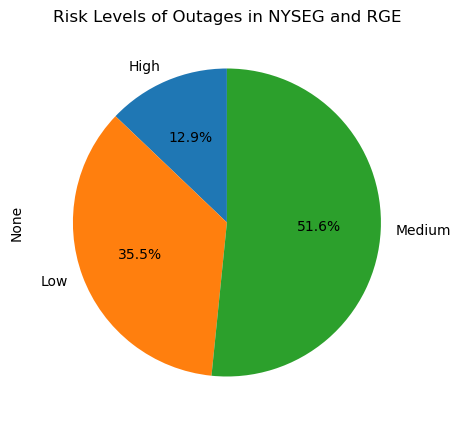

Medium    44050
Low       30332
High      10991
Name: risk, dtype: int64


In [27]:
# create pie chart for risk levels
import matplotlib.pyplot as plt

risk_levels = outages_distance_to_water.groupby('risk').size()
risk_levels.plot.pie(y='risk', figsize=(5, 5), autopct='%1.1f%%', startangle=90, title='Risk Levels of Outages in NYSEG and RGE')
plt.show()

# Count the number of confirmed osprey nests in each risk category
confirmed_nests_risk_counts = outages_distance_to_water['risk'].value_counts()
print(confirmed_nests_risk_counts)

In [31]:
import folium

m = folium.Map(location=[outages_distance_to_water['faultlatitude'].mean(), outages_distance_to_water['faultlongitude'].mean()], zoom_start=10)

# Function to add markers to the map based on risk
def add_marker(row):
    color = {'Low': 'green', 'Medium': 'orange', 'High': 'red'}
    folium.CircleMarker(
        location=[row['faultlatitude'], row['faultlongitude']],
        radius=1,
        fill_opacity=0.6,
        popup=f"Risk: {row['risk']}",
        color=color[row['risk']],
        fill=True,
        fill_color=color[row['risk']]
    ).add_to(m)

# Apply the function to the DataFrame
outages_distance_to_water.apply(add_marker, axis=1)

# Save the map to an HTML file or display it
m.save("outages_risk_map.html")  # Save to an HTML file


In [22]:
osprey_confirmed_nests.describe()

,faultlatitude,faultlongitude,KeyCustomers
count,131.000000,131.000000,0.0
mean,42.966440,-76.293639,NaN
std,0.520563,1.165836,NaN
min,41.590818,-78.648507,NaN
25%,42.738570,-76.806358,NaN
50%,42.858325,-76.703925,NaN
75%,43.066480,-76.530317,NaN
max,44.735840,-73.370350,NaN


c:\Users\palit\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


Confirmed Osprey Nests in Each Risk Category:
High      90
Medium    41
Name: risk, dtype: int64


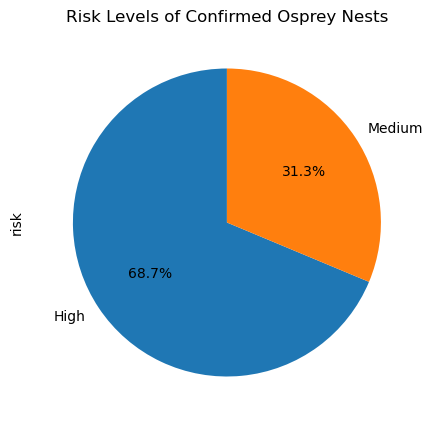

In [32]:
osprey_confirmed_nests = osprey_confirmed_nests.to_crs(crs=3857)
map_data = map_data.to_crs(crs=3857)

# Perform a spatial join with water bodies
osprey_confirmed_nests_near_water = gpd.sjoin(osprey_confirmed_nests, map_data, how='left', op='intersects')

# Calculate the distance to the nearest water body
osprey_confirmed_nests_near_water['nearest_waterbody_distance_km'] = osprey_confirmed_nests_near_water['geometry'].distance(map_data.unary_union) / 1000

# Define categories based on conditions
osprey_confirmed_nests_near_water['near_water'] = np.where(osprey_confirmed_nests_near_water['nearest_waterbody_distance_km'] <= 3, 'NW', 'AW')
osprey_confirmed_nests_near_water['near_nest'] = 'NN'  # Assume all confirmed nests are near nests

# Assign risk labels based on the desired categories
def assign_risk_label(row):
    if row['near_water'] == 'NW' and row['near_nest'] == 'NN':
        return 'High'
    elif (row['near_water'], row['near_nest']) in [('NW', 'NN'), ('AW', 'NN')]:
        return 'Medium'
    else:
        return 'Low'

osprey_confirmed_nests_near_water['risk'] = osprey_confirmed_nests_near_water.apply(assign_risk_label, axis=1)

# Count the number of confirmed osprey nests in each risk category
confirmed_nests_risk_counts = osprey_confirmed_nests_near_water['risk'].value_counts()

# Print the results
print("Confirmed Osprey Nests in Each Risk Category:")
print(confirmed_nests_risk_counts)

# Plot a pie chart for confirmed osprey nests in each risk category
confirmed_nests_risk_counts.plot.pie(
    y='risk',
    figsize=(5, 5),
    autopct='%1.1f%%',
    startangle=90,
    title='Risk Levels of Confirmed Osprey Nests'
)
plt.show()

In [36]:
# convert osprey_confirmed_nests_near_water to csv
osprey_confirmed_nests_near_water.to_csv('CapstoneData/risk_categories_validation_NY.csv', index=False)

In [33]:
import folium

m = folium.Map(location=[outages_distance_to_water['faultlatitude'].mean(), outages_distance_to_water['faultlongitude'].mean()], zoom_start=10)

# Function to add markers to the map based on risk
def add_marker(row):
    color = {'Low': 'green', 'Medium': 'orange', 'High': 'red'}
    folium.CircleMarker(
        location=[row['faultlatitude'], row['faultlongitude']],
        radius=5,
        popup=f"Risk: {row['risk']}",
        color=color[row['risk']],
        fill=True,
        fill_color=color[row['risk']]
    ).add_to(m)

# Apply the function to the DataFrame
osprey_confirmed_nests_near_water.apply(add_marker, axis=1)

# Save the map to an HTML file or display it
m.save("osprey_validation_risk_map.html")  # Save to an HTML file
